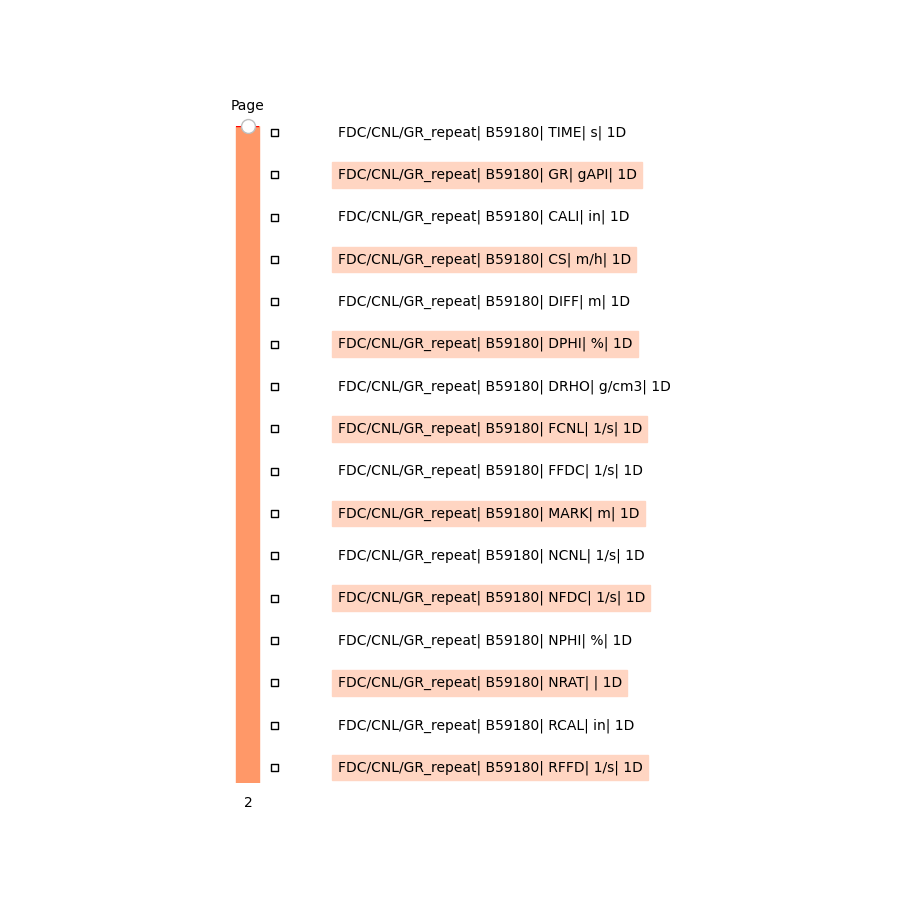

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from stoneforge.io.dlisio_r import DLISAccess
import pandas as pd

dlis_manager = DLISAccess("../stoneforge/datasets/DSDP_leg_96_hole_616_96_processed_data.dlis")

In [4]:
data = dlis_manager.get_data()
data

{'FDC/CNL/GR_main': {'B59067': {'TDEP': {'unit': 'm',
    'values': array([372.4656   , 372.3132   , 372.1608   , ...,  -4.1146564,
            -4.2670565,  -4.4194565], shape=(2474,), dtype=float32)},
   'RHOB': {'unit': 'g/cm3',
    'values': array([2.0898438, 2.0898438, 2.0898438, ..., 1.1201172, 1.1132812,
           1.109375 ], shape=(2474,), dtype=float32)},
   'GR': {'unit': 'gAPI',
    'values': array([133.25     , 133.25     , 133.25     , ...,   3.765625 ,
             3.7519531,   3.7539062], shape=(2474,), dtype=float32)},
   'CALI': {'unit': 'in',
    'values': array([7.8555613, 7.8555613, 7.8555613, ..., 7.898622 , 7.9232283,
           7.898622 ], shape=(2474,), dtype=float32)},
   'DRHO': {'unit': 'g/cm3',
    'values': array([ 0.04785156,  0.04785156,  0.04785156, ..., -0.42578125,
           -0.43408203, -0.43701172], shape=(2474,), dtype=float32)},
   'NPHI': {'unit': '%',
    'values': array([ 61.279297,  61.279297,  61.279297, ...,  96.728516, 106.640625,
         